In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
from functools import reduce
import numpy.ma as ma
import scipy.interpolate
import numpy as np
import xarray as xr
import sys,time,os
import random, warnings
from plotting_utilities import *
from thermodynamic_functions import *

farbe = sim_colors()

# Comparison of StratoClim in-situ and ICON synthetic trajectory vertical profiles

### (1) Read in-situ data and group by altitude

In [2]:
# Read in-situ data
#daten = xr.open_dataset('obs/stratoclim2017.geophysika.0808_1.master.ci_eval.nc')  # In-situ not filtered for whole-second values
daten = xr.open_dataset('obs/stratoclim2017.geophysika.0808_1.filtered_per_sec.nc')

# Time range from Lee et al. 2019 (6:20-6:48 UTC)
time0 = datetime(2017, 8, 8, 6, 20)
timef = datetime(2017, 8, 8, 6, 48)
zeit = daten['time'].sel( time=slice(time0, timef) ) 

# Extract values between 6:20 and 6:48 UTC as in Lee et al. 2019
alt = daten['BEST:ALT'].sel( time=slice(time0, timef) )
qv_flash = daten['BEST:H2O_gas'].sel( time=slice(time0, timef) )
qv_fish = daten['BEST:H2O_enh'].sel( time=slice(time0, timef) )
qi = daten['BEST:IWC'].sel( time=slice(time0, timef) )
temp = daten['BEST:TEMP'].sel( time=slice(time0, timef) )
theta = daten['BEST:THETA'].sel( time=slice(time0, timef) )
rhice_flash = daten['BEST:RH_ice_gas'].sel( time=slice(time0, timef) )
rhice_fish = daten['BEST:RH_ice_enh'].sel( time=slice(time0, timef) )

lat = daten['BEST:LAT'].sel( time=slice(time0, timef) )
lon = daten['BEST:LON'].sel( time=slice(time0, timef) )
print('In-situ lat min: ' + str(lat.min(skipna=True).values) + ' // In-situ lat max: ' + str(lat.max(skipna=True).values))
print('In-situ lon min: ' + str(lon.min(skipna=True).values) + ' // In-situ lon max: ' + str(lon.max(skipna=True).values))

In-situ lat min: 25.730899810791016 // In-situ lat max: 27.427600860595703
In-situ lon min: 85.18689727783203 // In-situ lon max: 85.31770324707031


In [3]:
# Extract corresponding altitudes and times for different variables according to their non-zero values
alt1 = alt.where( (alt > 0) & (qv_flash > 0) & (qv_fish > 0) ).values
t1 = zeit.where( (alt > 0) & (qv_flash > 0) & (qv_fish > 0) )
qv_flash = qv_flash.where( (alt > 0) & (qv_flash > 0) & (qv_fish > 0) )
qv_fish = qv_fish.where( (alt > 0) & (qv_flash > 0) & (qv_fish > 0) )

alt2 = alt.where( (alt > 0) & (qi > 0) )
qi = qi.where( (alt > 0) & (qi > 0) )

alt3 = alt.where( (temp > 0) & (theta > 0) )
temp = temp.where( (temp > 0) & (theta > 0) )
theta = theta.where( (temp > 0) & (theta > 0) )

alt4 = alt.where( (rhice_flash > 0) & (rhice_fish > 0) )
rhice_flash = rhice_flash.where( (rhice_flash > 0) & (rhice_fish > 0) )
rhice_fish = rhice_fish.where( (rhice_flash > 0) & (rhice_fish > 0) )

In [4]:
# Define the simulation bins from the vertical grid file
vgrid = xr.open_dataset('/work/bb1018/b380873/vgrid_icon-grid_tropic_55e115e5s40n.nc')
alt = vgrid.vct_a.values[:,0]
j = np.argwhere((alt >= 14000) & (alt <= 22000))
bins_sims = alt[j[:,0]]

In [5]:
# Binning in altitude between <u> and <d> with <n> bins, which elements go in which bin?
# Make a multidimensional list of alt and h2o values in each.
#u = 14000
#d = 22000
#n = 70

# np.digitize returns the indices of the bins to which each element in alt* belongs.
#i1 = np.digitize( alt1, bins=np.linspace(u,d,n) )
#i2 = np.digitize( alt2, bins=np.linspace(u,d,n) )
#i3 = np.digitize( alt3, bins=np.linspace(u,d,n) )

# np.digitize returns the indices of the bins to which each element in alt* belongs.
icon_n = 13
i1 = np.digitize( alt1, bins=bins_sims )
i2 = np.digitize( alt2, bins=bins_sims )
i3 = np.digitize( alt3, bins=bins_sims )
i4 = np.digitize( alt4, bins=bins_sims )

alt1_list = [ [] for i in np.arange(icon_n) ]
t_list = [ [] for i in np.arange(icon_n) ]
qv_flash_list = [ [] for i in np.arange(icon_n) ]
qv_fish_list = [ [] for i in np.arange(icon_n) ]

alt2_list = [ [] for i in np.arange(icon_n) ]
qi_list = [ [] for i in np.arange(icon_n) ]

alt3_list = [ [] for i in np.arange(icon_n) ]
temp_list = [ [] for i in np.arange(icon_n) ]
theta_list = [ [] for i in np.arange(icon_n) ]

alt4_list = [ [] for i in np.arange(icon_n) ]
RHi_list = [ [] for i in np.arange(icon_n) ]

In [6]:
# Group values into these bins
for elem_idx, group_idx in enumerate(i1):
    alt1_list[group_idx-1].append( alt1[elem_idx].item() )
    t_list[group_idx-1].append( t1[elem_idx].item() )
    qv_flash_list[group_idx-1].append( qv_flash[elem_idx].item() )
    qv_fish_list[group_idx-1].append( qv_fish[elem_idx].item() )

for elem_idx, group_idx in enumerate(i2):
    alt2_list[group_idx-1].append( alt2[elem_idx].item() )
    qi_list[group_idx-1].append( qi[elem_idx].item() )

for elem_idx, group_idx in enumerate(i3):
    alt3_list[group_idx-1].append( alt3[elem_idx].item() )
    temp_list[group_idx-1].append( temp[elem_idx].item() )
    theta_list[group_idx-1].append( theta[elem_idx].item() )

for elem_idx, group_idx in enumerate(i4):
    alt4_list[group_idx-1].append( alt4[elem_idx].item() )
    RHi_list[group_idx-1].append( rhice_flash[elem_idx].item() )

In [7]:
# Calculate the statistics across all items in a bin if there are at least 5 such items
icon_n = 13
temp_SC_stats = np.empty((3, icon_n))
temp_SC_stats[:] = np.nan
theta_SC_stats = np.empty((3, icon_n))
theta_SC_stats[:] = np.nan
qv_flash_SC_stats = np.empty((3, icon_n))
qv_flash_SC_stats[:] = np.nan
qv_fish_SC_stats = np.empty((3, icon_n))
qv_fish_SC_stats[:] = np.nan
qi_SC_stats = np.empty((3, icon_n))
qi_SC_stats[:] = np.nan
RHi_SC_stats = np.empty((3, icon_n))
RHi_SC_stats[:] = np.nan
    
for i in np.arange(icon_n):
    if (len(temp_list[i]) > 5):
        temp_SC_stats[0,i] = np.nanmean( temp_list[i] )
        temp_SC_stats[1,i] = np.nanmedian( temp_list[i] )
        temp_SC_stats[2,i] = np.nanstd( temp_list[i] )
        theta_SC_stats[0,i] = np.nanmean( theta_list[i] )
        theta_SC_stats[1,i] = np.nanmedian( theta_list[i] )
        theta_SC_stats[2,i] = np.nanstd( theta_list[i] )
    if (len(qv_flash_list[i]) > 5):
        qv_flash_SC_stats[0,i] = np.nanmean( qv_flash_list[i] )
        qv_flash_SC_stats[1,i] = np.nanmedian( qv_flash_list[i] )
        qv_flash_SC_stats[2,i] = np.nanstd( qv_flash_list[i] )
    if (len(qv_fish_list[i]) > 5):
        qv_fish_SC_stats[0,i] = np.nanmean( qv_fish_list[i] )
        qv_fish_SC_stats[1,i] = np.nanmedian( qv_fish_list[i] )
        qv_fish_SC_stats[2,i] = np.nanstd( qv_fish_list[i] )
    if (len(qi_list[i]) > 5):
        qi_SC_stats[0,i] = np.nanmean( qi_list[i] )
        qi_SC_stats[1,i] = np.nanmedian( qi_list[i] )
        qi_SC_stats[2,i] = np.nanstd( qi_list[i] )
    if (len(RHi_list[i]) > 5):
        RHi_SC_stats[0,i] = np.nanmean( RHi_list[i] )
        RHi_SC_stats[1,i] = np.nanmedian( RHi_list[i] )
        RHi_SC_stats[2,i] = np.nanstd( RHi_list[i] )

### (2a) Functions to handle the synthetic trajectories

In [8]:
# How many elements per bin from the in-situ measurements? These will be used in syn_traj_stats_fixed below.
temp_len = []
qv_flash_len = []
for i in np.arange(icon_n):
    temp_len.append( int(len(temp_list[i])) )
    qv_flash_len.append( int(len(qv_flash_list[i])) )

# The whole second set of trajectories (z ~ 22 km) are piled into the last bin.
# Remove this bin as we're interested in the vertical profile lower down.
temp_len[-1] = -9999
qv_flash_len[-1] = -9999
#np.save( 'output/Stratoclim_temp_len.npy', np.asarray(temp_len, dtype='i4') )
#np.save( 'output/Stratoclim_qv_len.npy', np.asarray(qv_flash_len, dtype='i4') )

In [9]:
# Calculate the mean, median, and standard deviation of <var> in a given set of simulation trajs
# This function does not fix the number of elements per bin.
# var_names = ['temp', 'air_pressure', 'qv', 'qc', 'qi', 'qs', 'qg', 'clc', 'omega', 'alt', 'lon', 'lat']

def syn_traj_stats( alt_ICON, fi_ICON, indx, bins_sim, var ):
    
    # Store 3 statistics over <n> bins for 625 trajectories
    n = bins_sim.shape[0]
    stats = np.empty((3, n, alt_ICON.shape[1]))
    stats[:] = np.nan
    
    for i in np.arange(alt_ICON.shape[1]):
        print(i)
        var_list = [ [] for k in np.arange(n) ]
        
        # Group <var> values along this trajectory into bins
        for elem_idx, group_idx in enumerate( indx[:, i] ):
            var_list[int(group_idx-1)].append( fi_ICON[var][elem_idx, i].item() )
        
        # Calculate statistics in each bin
        for k in np.arange(n):
            stats[0, k, i] = np.nanmean( var_list[k] )
            stats[1, k, i] = np.nanmedian( var_list[k] )
            stats[2, k, i] = np.nanstd( var_list[k] )
                
    return stats

In [10]:
# Calculate the mean, median, and standard deviation of <var> in a given set of simulation trajs
# This function fixes the number of elements per bin.
# var_names = ['temp', 'air_pressure', 'qv', 'qc', 'qi', 'qs', 'qg', 'clc', 'omega', 'alt', 'lon', 'lat']

def syn_traj_stats_fixed( alt_ICON, fi_ICON, indx, bins_sim, var ):
    
    # Store 3 statistics over <n> bins for 625 trajectories
    n = bins_sim.shape[0]
    stats = np.empty((3, n, alt_ICON.shape[1]))
    stats[:] = np.nan
    
    # Read in the number of in-situ measurements in each bin
    basedir = '/work/bb1018/b380873/tropic_vis/'
    Stratoclim_temp_len = np.load(basedir + 'output/Stratoclim_temp_len.npy')
    Stratoclim_qv_len = np.load(basedir + 'output/Stratoclim_qv_len.npy')
    
    for i in np.arange(5):#alt_ICON.shape[1]):
        #if i%50 == 0:
        print(i)
        var_list = [ [] for i in np.arange(n) ]

        # Group <var> values along this trajectory into bins.
        for elem_idx, group_idx in enumerate( indx[:,i] ):
            var_list[int(group_idx-1)].append( fi_ICON[var][elem_idx, i].item() )
    
        # Only retain the corresponding number of elements from the measurements
        # We do this calculation only for n-1 bins as the last bin contains the whole "upper-level" trajectory set (z ~ 22 km)
        var_list_fixed = [ [] for i in np.arange(n) ]
        for j in np.arange(n-1):
            if var_list[j]:
                var_list_fixed[j] = random.sample( var_list[j], Stratoclim_temp_len[j] )  
                # To be revisited above, whether Stratoclim_temp_len[j] is relevant for all variables
        
            if var_list_fixed[j]:
                stats[0, j, i] = np.nanmean( var_list_fixed[j] )
                stats[1, j, i] = np.nanmedian( var_list_fixed[j] )
                stats[2, j, i] = np.nanstd( var_list_fixed[j] )
            
    return stats

### (2b) Read synthetic trajectories and group by altitude
#### The first four cells have been migrated to statme.py for sbatch submission as the fourth and fifth cells take almost 2 hours each.

In [11]:
# Do the same for the synthetic simulation trajectories
basedir = '/work/bb1018/b380873/model_output/ICON/'
syntraj1 = xr.open_dataset(basedir + 'ICON_synthetic_trajs_0V1M0A0R.nc')
syntraj2 = xr.open_dataset(basedir + 'ICON_synthetic_trajs_0V2M0A0R.nc')
syntraj3 = xr.open_dataset(basedir + 'ICON_synthetic_trajs_0V2M1A1R.nc')

alt_ICON1 = syntraj1['alt'].sel( time=slice(time0, timef) )
alt_ICON2 = syntraj2['alt'].sel( time=slice(time0, timef) )
alt_ICON3 = syntraj3['alt'].sel( time=slice(time0, timef) )

In [12]:
# Binning in altitude between <u> and <d> with <n> bins, which elements go in which bin?
# np.digitize returns the indices of the bins to which each element in alt* belongs.
# 3 sets of simulations, 1681 times, 625 trajectories
idx = np.zeros((3, alt_ICON1.shape[0], alt_ICON1.shape[1]))
for i in np.arange(alt_ICON1.shape[1]):
    idx[0,:,i] = np.digitize( alt_ICON1[:,i], bins=bins_sims ) #bins=np.linspace(u,d,n) )
    idx[1,:,i] = np.digitize( alt_ICON2[:,i], bins=bins_sims ) #bins=np.linspace(u,d,n) )
    idx[2,:,i] = np.digitize( alt_ICON3[:,i], bins=bins_sims ) #bins=np.linspace(u,d,n) )

In [13]:
stats1 = np.load('output/ICON_syntrajs_0V1M0A0R_stats_thermo.npy')  #'ICON_syntrajs_0V1M0A0R_stats_70bins.npy'
stats2 = np.load('output/ICON_syntrajs_0V2M0A0R_stats_thermo.npy')  #'ICON_syntrajs_0V2M0A0R_stats_70bins.npy'
stats3 = np.load('output/ICON_syntrajs_0V2M1A1R_stats_thermo.npy')  #'ICON_syntrajs_0V2M1A1R_stats_70bins.npy'

In [14]:
stats1_fixed = np.load('output/ICON_syntrajs_0V1M0A0R_stats_fixed_thermo.npy') #'ICON_syntrajs_0V1M0A0R_stats_fixed_70bins.npy'
stats2_fixed = np.load('output/ICON_syntrajs_0V2M0A0R_stats_fixed_thermo.npy') #'ICON_syntrajs_0V2M0A0R_stats_fixed_70bins.npy'
stats3_fixed = np.load('output/ICON_syntrajs_0V2M1A1R_stats_fixed_thermo.npy') #'ICON_syntrajs_0V2M1A1R_stats_fixed_70bins.npy'

### (2c) Read ideal trajectory and group by altitude

In [ ]:
stats1_ideal = np.load('output/ICON_idealtraj_0V1M0A0R_stats.py')
stats2_ideal = np.load('output/ICON_idealtraj_0V2M0A0R_stats.py')
stats3_ideal = np.load('output/ICON_idealtraj_0V2M1A1R_stats.py')

### (3a) Plot vertical profiles of temperature and qv for both in-situ measurements and ICON synthetic trajectories

In [15]:
s1 = stats1; s2 = stats2; s3 = stats3
#s1 = stats1_fixed; s2 = stats2_fixed; s3 = stats3_fixed
warnings.filterwarnings(action='once')
sim_stats = np.stack((s1, s2, s3))
sim_list = ['0V1M0A0R', '0V2M0A0R', '0V2M1A1R']

In [17]:
# Calculate the potential temperature from the pure temperature
#n = 70
n = 13
theta_ICON = np.empty((3, 3, n, 625))
theta_ICON[:] = np.nan
RH_ICON = np.empty((3, 3, n, 625))
RH_ICON[:] = np.nan

theta_ICON = calc_theta(sim_stats[:,0], sim_stats[:,1])
RH_ICON = calc_RH(sim_stats[:,0], sim_stats[:,1], sim_stats[:,2])

In [23]:
# Load the synthetic traj ice mass mixing ratios in altitude bins, convert to ppmv
mw_dryair = 28.97*1000    # kg air (mol air)-1
mw_watvap = 18.02*1000    # kg wv (mol wv)-1
conv = mw_dryair / mw_watvap
qi_ICON1 = np.load('output/ICON_syntrajs_0V1M0A0R_stats_fixed_qi.npy') * conv * 10**6
qi_ICON2 = np.load('output/ICON_syntrajs_0V2M0A0R_stats_fixed_qi.npy') * conv * 10**6
qi_ICON3 = np.load('output/ICON_syntrajs_0V2M1A1R_stats_fixed_qi.npy') * conv * 10**6
qi_ICON = np.stack((qi_ICON1, qi_ICON2, qi_ICON3))

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


Text(0.03, 0.93, '(d)')

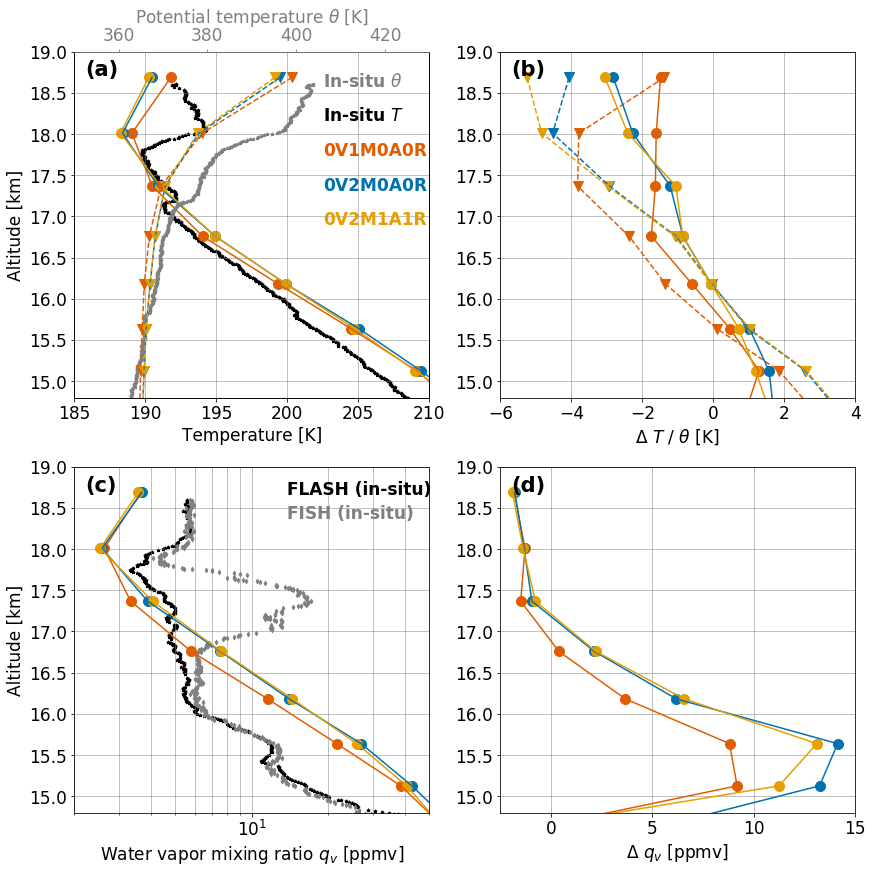

In [33]:
fs = 17
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
y1 = 14.8
y2 = 19
icon_sz = 100
icon_lw = 1.5
icon_alfa = 1
k = 0 # If k = 0, compare means. If k = 1, compare medians.
# Whether we look at stats or stats_fixed is set above.

ax[0,0].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
ax[0,0].scatter(temp, alt3/1000, color='k', s=10, marker='*')
for s_indx, s_name in enumerate( sim_list ):
    # np.linspace(u,d,n)/1000 were the initial y-coordinates
    ax[0,0].scatter(np.nanmean(sim_stats[s_indx,0,k,:,:20],axis=1), bins_sims/1000, s=icon_sz, color=farbe[s_name]) 
    ax[0,0].plot(np.nanmean(sim_stats[s_indx,0,k,:,:20],axis=1), bins_sims/1000, linewidth=icon_lw, color=farbe[s_name]) 
ax[0,0].set_ylim([y1, y2])
ax[0,0].set_xlim([185, 210])
ax[0,0].tick_params('both',labelsize=fs)
ax[0,0].set_xlabel('Temperature [K]', fontsize=fs)
ax[0,0].set_ylabel('Altitude [km]',fontsize=fs)
ax[0,0].text(0.03, 0.93, '(a)', weight='bold', fontsize=fs+4, transform=ax[0,0].transAxes)

ax0 = ax[0,0].twiny()
ax0.scatter(theta, alt3/1000, color='gray', s=10, marker='*')
for s_indx, s_name in enumerate( sim_list ):
    ax0.scatter(np.nanmean(theta_ICON[s_indx,k,:,:20], axis=1), bins_sims/1000, marker='v', s=icon_sz, color=farbe[s_name])
    ax0.plot(np.nanmean(theta_ICON[s_indx,k,:,:20],axis=1), bins_sims/1000, ls='--', linewidth=icon_lw, color=farbe[s_name])
ax0.set_xlabel(r'Potential temperature $\theta$ [K]', fontsize=fs, color='gray')
ax0.spines['top'].set_color('gray')
ax0.tick_params(axis='x',colors='gray')
ax0.set_xlim([350, 430])
ax0.tick_params('both',labelsize=fs)
ax0.text(0.7, 0.9, r'In-situ $\theta$', fontsize=fs, weight='bold', color='gray', transform=ax0.transAxes)
ax0.text(0.7, 0.8, r'In-situ $T$', fontsize=fs, weight='bold', color='black', transform=ax0.transAxes)
ax0.text(0.7, 0.7, '0V1M0A0R', fontsize=fs, weight='bold', color=farbe['0V1M0A0R'], transform=ax0.transAxes)
ax0.text(0.7, 0.6, '0V2M0A0R', fontsize=fs, weight='bold', color=farbe['0V2M0A0R'], transform=ax0.transAxes)
ax0.text(0.7, 0.5, '0V2M1A1R', fontsize=fs, weight='bold', color=farbe['0V2M1A1R'], transform=ax0.transAxes)

ax[0,1].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
for s_indx, s_name in enumerate( sim_list ):
    ax[0,1].scatter(np.nanmean(sim_stats[s_indx,0,k,:,:20],axis=1) - temp_SC_stats[k], bins_sims/1000, 
                    s=icon_sz, alpha=icon_alfa, color=farbe[s_name])
    ax[0,1].plot(np.nanmean(sim_stats[s_indx,0,k,:,:20],axis=1) - temp_SC_stats[k], bins_sims/1000, 
                 linewidth=icon_lw, color=farbe[s_name])
    ax[0,1].scatter(np.nanmean(theta_ICON[s_indx,k,:,:20],axis=1) - theta_SC_stats[k], bins_sims/1000, 
                    s=icon_sz, marker='v', alpha=icon_alfa, color=farbe[s_name])
    ax[0,1].plot(np.nanmean(theta_ICON[s_indx,k,:,:20],axis=1) - theta_SC_stats[k], bins_sims/1000, 
                 linewidth=icon_lw, ls='--', color=farbe[s_name])   
ax[0,1].set_ylim([y1, y2])
ax[0,1].set_xlim([-6, 4])
ax[0,1].tick_params('both',labelsize=fs)
ax[0,1].set_xlabel(r'$\Delta$ $T$ / $\theta$ [K]', fontsize=fs)
ax[0,1].text(0.03, 0.93, '(b)', weight='bold', fontsize=fs+4, transform=ax[0,1].transAxes)

ax[1,0].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
ax[1,0].scatter(qv_flash, alt1/1000, color='k', s=10, marker='*')
ax[1,0].scatter(qv_fish, alt1/1000, color='gray', s=10, marker='d')
for s_indx, s_name in enumerate( sim_list ):
    ax[1,0].scatter(np.nanmean(sim_stats[s_indx,2,k,:,:20],axis=1), bins_sims/1000, s=icon_sz, color=farbe[s_name])
    ax[1,0].plot(np.nanmean(sim_stats[s_indx,2,k,:,:20],axis=1), bins_sims/1000, linewidth=icon_lw, color=farbe[s_name])
ax[1,0].set_xlabel('Water vapor mixing ratio $q_v$ [ppmv]',fontsize=fs)
ax[1,0].set_ylabel('Altitude [km]',fontsize=fs)
ax[1,0].set_xlim(2,50)
ax[1,0].set_ylim([y1, y2])
ax[1,0].set_xscale('log')
ax[1,0].text(0.6, 0.92, 'FLASH (in-situ)', fontsize=fs, weight='bold', transform=ax[1,0].transAxes)
ax[1,0].text(0.6, 0.85, 'FISH (in-situ)', fontsize=fs, weight='bold', color='gray', transform=ax[1,0].transAxes)
ax[1,0].tick_params('both', labelsize=fs)
ax[1,0].text(0.03, 0.93, '(c)', weight='bold', fontsize=fs+4, transform=ax[1,0].transAxes)

ax[1,1].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
for s_indx, s_name in enumerate( sim_list ):
    ax[1,1].scatter(np.nanmean(sim_stats[s_indx,2,k,:,:20],axis=1) - qv_flash_SC_stats[k], bins_sims/1000, 
                    s=icon_sz, alpha=icon_alfa, color=farbe[s_name])
    ax[1,1].plot(np.nanmean(sim_stats[s_indx,2,k,:,:20],axis=1) - qv_flash_SC_stats[k], bins_sims/1000, 
                 linewidth=icon_lw, color=farbe[s_name])
ax[1,1].set_ylim([y1, y2])
ax[1,1].set_xlim([-2.5, 15])
ax[1,1].tick_params('both', labelsize=fs)
ax[1,1].set_xlabel(r'$\Delta$ $q_v$ [ppmv]', fontsize=fs)
ax[1,1].text(0.03, 0.93, '(d)', weight='bold', fontsize=fs+4, transform=ax[1,1].transAxes)

#fig.savefig('output/T-theta-qv-comp.pdf')

### (3b) Plot vertical profiles of RHi and qi for both in-situ measurements and ICON synthetic trajectories

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


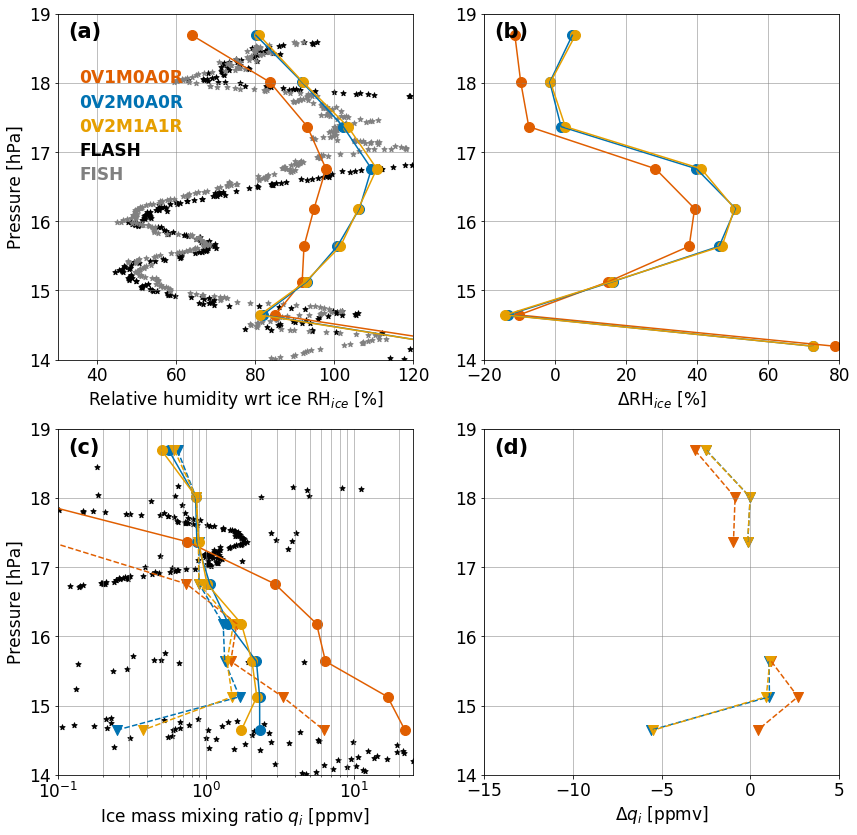

In [24]:
fs = 17
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
y1 = 14
y2 = 19
icon_sz = 100
icon_lw = 1.5
icon_alfa = 1
k = 0 # If k = 0, compare means. If k = 1, compare medians.

ax[0,0].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
ax[0,0].scatter(rhice_fish, alt4/1000, color='k', s=30, marker='*')
ax[0,0].scatter(rhice_flash, alt4/1000, color='gray', s=30, marker='*')
for s_indx, s_name in enumerate( sim_list ):
    ax[0,0].scatter(np.nanmean(RH_ICON[s_indx,k], axis=1), bins_sims/1000, color=farbe[s_name], s=icon_sz)
    ax[0,0].plot(np.nanmean(RH_ICON[s_indx,k], axis=1), bins_sims/1000, color=farbe[s_name], lw=icon_lw)
ax[0,0].text(0.06, 0.8, '0V1M0A0R', fontsize=fs, weight='bold', color=farbe['0V1M0A0R'], transform=ax[0,0].transAxes)
ax[0,0].text(0.06, 0.73, '0V2M0A0R', fontsize=fs, weight='bold', color=farbe['0V2M0A0R'], transform=ax[0,0].transAxes)
ax[0,0].text(0.06, 0.66, '0V2M1A1R', fontsize=fs, weight='bold', color=farbe['0V2M1A1R'], transform=ax[0,0].transAxes)
ax[0,0].text(0.06, 0.59, 'FLASH', fontsize=fs, weight='bold', transform=ax[0,0].transAxes)
ax[0,0].text(0.06, 0.52, 'FISH', fontsize=fs, weight='bold', color='gray', transform=ax[0,0].transAxes)
ax[0,0].set_ylim([y1, y2])
ax[0,0].set_xlim([30, 120])
ax[0,0].set_xlabel(r'Relative humidity wrt ice RH$_{ice}$ [%]', fontsize=fs)
ax[0,0].set_ylabel('Pressure [hPa]', fontsize=fs)
ax[0,0].tick_params('both',labelsize=fs)
ax[0,0].text(0.03, 0.93, '(a)', weight='bold', fontsize=fs+4, transform=ax[0,0].transAxes)

ax[0,1].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
for s_indx, s_name in enumerate( sim_list ):
    ax[0,1].scatter(np.nanmean(RH_ICON[s_indx,k], axis=1) - RHi_SC_stats[k], bins_sims/1000, color=farbe[s_name], s=icon_sz)
    ax[0,1].plot(np.nanmean(RH_ICON[s_indx,k], axis=1) - RHi_SC_stats[k], bins_sims/1000, color=farbe[s_name], lw=icon_lw)
ax[0,1].set_ylim([y1, y2])
ax[0,1].set_xlim([-20, 80])
ax[0,1].set_xlabel(r'$\Delta$RH$_{ice}$ [%]', fontsize=fs)
ax[0,1].tick_params('both',labelsize=fs)
ax[0,1].text(0.03, 0.93, '(b)', weight='bold', fontsize=fs+4, transform=ax[0,1].transAxes)

ax[1,0].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
ax[1,0].scatter(qi, alt2/1000, color='k', s=30, marker='*')

# We don't use k below because we are showing both the mean and median always.
for s_indx, s_name in enumerate( sim_list ):
    ax[1,0].scatter(np.nanmean(qi_ICON[s_indx,0], axis=1), bins_sims/1000, color=farbe[s_name], s=icon_sz)
    ax[1,0].plot(np.nanmean(qi_ICON[s_indx,0], axis=1), bins_sims/1000, color=farbe[s_name], lw=icon_lw)
    ax[1,0].scatter(np.nanmedian(qi_ICON[s_indx,1], axis=1), bins_sims/1000, marker='v', color=farbe[s_name], s=icon_sz)
    ax[1,0].plot(np.nanmedian(qi_ICON[s_indx,1], axis=1), bins_sims/1000, ls='--', color=farbe[s_name], lw=icon_lw)
ax[1,0].set_ylim([y1, y2])
ax[1,0].set_xlim([0.1, 25])
ax[1,0].set_xscale('log')
ax[1,0].set_xlabel(r'Ice mass mixing ratio $q_i$ [ppmv]', fontsize=fs)
ax[1,0].tick_params('both',labelsize=fs)
ax[1,0].text(0.03, 0.93, '(c)', weight='bold', fontsize=fs+4, transform=ax[1,0].transAxes)
ax[1,0].set_ylabel('Pressure [hPa]', fontsize=fs)

ax[1,1].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
for s_indx, s_name in enumerate( sim_list ):
    #ax[1,1].scatter(np.nanmean(qi_ICON[s_indx,0], axis=1) - qi_SC_stats[0], bins_sims/1000, color=farbe[s_name], s=icon_sz)
    #ax[1,1].plot(np.nanmean(qi_ICON[s_indx,0], axis=1) - qi_SC_stats[0], bins_sims/1000, color=farbe[s_name], lw=icon_lw)
    ax[1,1].scatter(np.nanmedian(qi_ICON[s_indx,1], axis=1) - qi_SC_stats[1], bins_sims/1000, marker='v', color=farbe[s_name], s=icon_sz)
    ax[1,1].plot(np.nanmedian(qi_ICON[s_indx,1], axis=1) - qi_SC_stats[1], bins_sims/1000, ls='--', color=farbe[s_name], lw=icon_lw)
ax[1,1].set_ylim([y1, y2])
ax[1,1].set_xlim([-15, 5])
#ax[1,1].set_xscale('log')
ax[1,1].set_xlabel(r'$\Delta q_i$ [ppmv]', fontsize=fs)
ax[1,1].tick_params('both',labelsize=fs)
ax[1,1].text(0.03, 0.93, '(d)', weight='bold', fontsize=fs+4, transform=ax[1,1].transAxes)

#fig.savefig('output/RHi-qi-comp_fixed.pdf')

### (4) Function to generate 'ideal' trajectory

## How much variability in the synthetic trajectories?

In [67]:
basedir = '/work/bb1018/b380873/model_output/ICON/'
syn_traj = xr.open_dataset(basedir + 'ICON_synthetic_trajs.nc')
w = syn_traj['omega'].isel(time=slice(0,10800))
t = syn_traj['time'].isel(time=slice(0,10800)).values

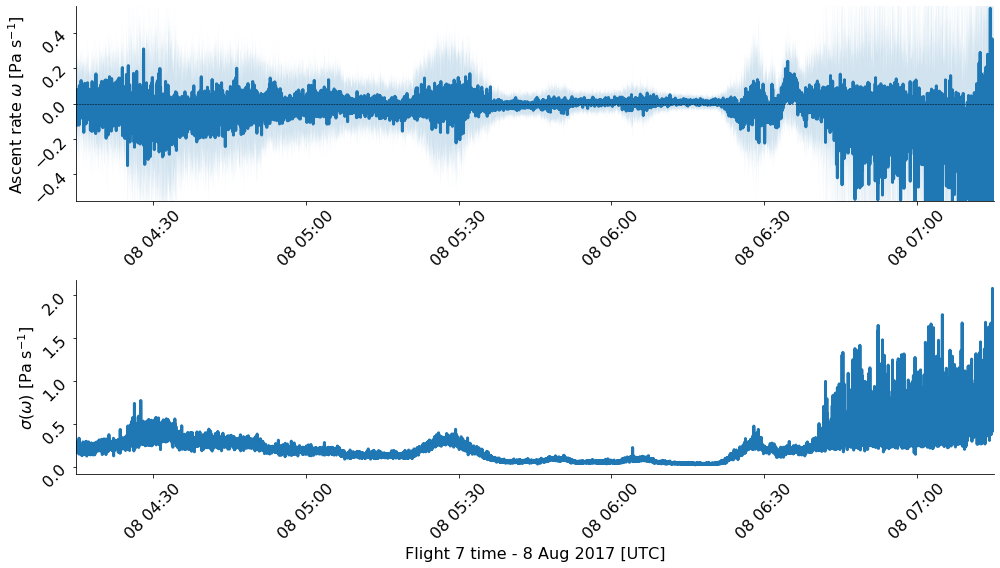

In [69]:
fs = 16
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14,8))
wm = w.mean(dim='ntraj')
wstd = w.std(dim='ntraj')
ax[0].plot(t, wm, linewidth=3)
ax[0].plot([t.min(), t.max()], [0, 0], color='k', linestyle='--', linewidth=0.5)
ax[0].plot()
ax[0].fill_between(t, wm - wstd, wm + wstd, alpha=0.2)
ax[0].set_xlim([t.min(), t.max()])
ax[0].set_ylim([-0.55, 0.55])
ax[0].set_ylabel(r'Ascent rate $\omega$ [Pa s$^{-1}$]', fontsize=fs)
sexy_axes(ax[0], fs=16)

ax[1].plot(t, wstd, linewidth=3)
ax[1].set_xlim([t.min(), t.max()])
ax[1].set_xlabel('Flight 7 time - 8 Aug 2017 [UTC]', fontsize=fs)
ax[1].set_ylabel(r'$\sigma(\omega)$ [Pa s$^{-1}$]', fontsize=fs)
sexy_axes(ax[1], fs)
plt.tight_layout()
#fig.savefig('output/syntraj_wcheck_full.pdf',bbox_inches='tight')
plt.show()

In [107]:
T = syn_traj['temp'].isel(time=slice(0,10800))
t = syn_traj['time'].isel(time=slice(0,10800)).values

# Read in-situ data
daten = xr.open_dataset('obs/stratoclim2017.geophysika.0808_1.filtered_per_sec.nc')
j = 1942
T_Stratoclim = daten['BEST:TEMP'][j:j+10801]
t_Stratoclim = daten['time'][j:j+10801]

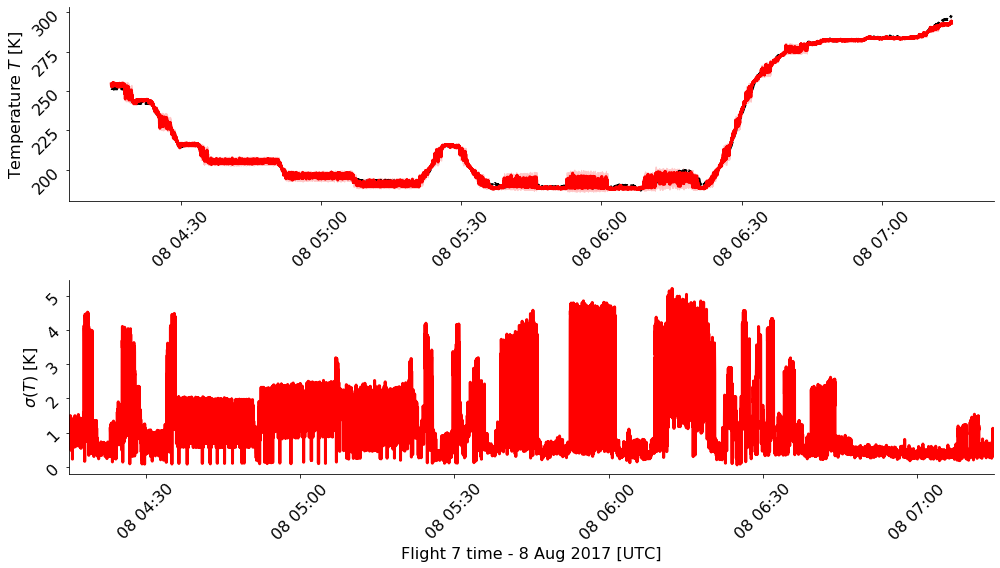

In [108]:
fs = 16
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14,8))
Tm = T.mean(dim='ntraj')
Tstd = T.std(dim='ntraj')
ax[0].plot(t_Stratoclim, T_Stratoclim, color='k', linewidth=2.5, linestyle='--')
ax[0].plot(t, Tm, color='red', linewidth=3)
ax[0].fill_between(t, Tm - Tstd, Tm + Tstd, color='red', alpha=0.2)
#ax[0].set_xlim([t.min(), t.max()])
ax[0].set_ylabel(r'Temperature $T$ [K]', fontsize=fs)
sexy_axes(ax[0], fs=16)

ax[1].plot(t, Tstd, color='red', linewidth=3)
ax[1].set_xlim([t.min(), t.max()])
ax[1].set_xlabel('Flight 7 time - 8 Aug 2017 [UTC]', fontsize=fs)
ax[1].set_ylabel(r'$\sigma(T)$ [K]', fontsize=fs)
sexy_axes(ax[1], fs)
plt.tight_layout()

fig.savefig('output/syntraj_Tcheck_full.pdf',bbox_inches='tight')
plt.show()

In [131]:
qi = syn_traj['qi'].isel(time=slice(0,10800))
t = syn_traj['time'].isel(time=slice(0,10800)).values

# Multiply qv_s by 10^6 to translate kg kg-1 to ppmv.
mw_dryair = 28.97*1000    # kg air (mol air)-1
mw_watvap = 18.02*1000    # kg wv (mol wv)-1
conv = mw_dryair / mw_watvap
qim_ppmv = qi.mean(dim='ntraj') * conv * 10**6
qistd_ppmv = qi.std(dim='ntraj') * conv * 10**6

# Read in-situ data
daten = xr.open_dataset('obs/stratoclim2017.geophysika.0808_1.filtered_per_sec.nc')
j = 1942
qi_Stratoclim = daten['BEST:IWC'][j:j+10801]
t_Stratoclim = daten['time'][j:j+10801]

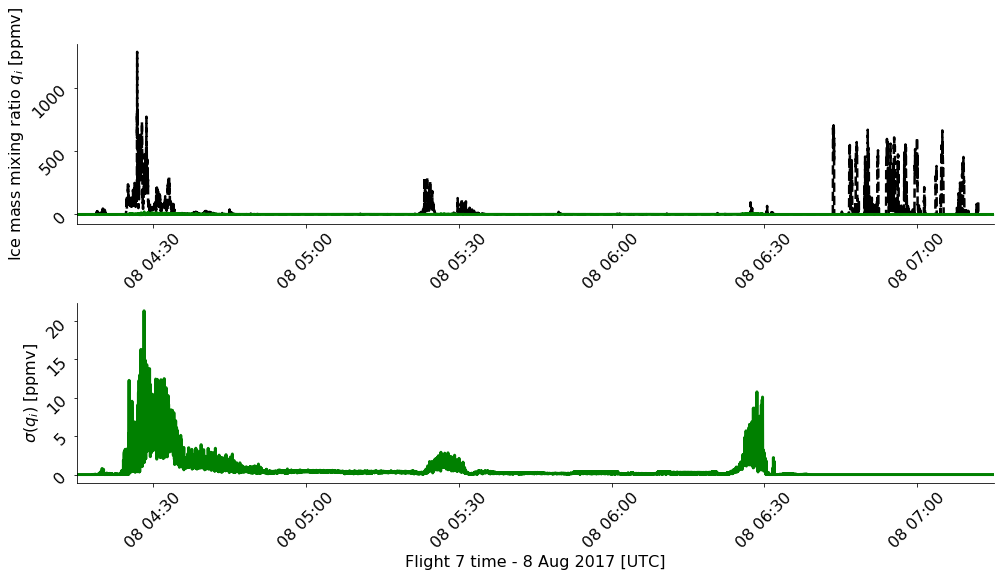

In [133]:
fs = 16
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14,8))
ax[0].plot(t_Stratoclim, qi_Stratoclim, color='k', linewidth=2.5, linestyle='--')
ax[0].plot(t, qim_ppmv, color='green', linewidth=3)
ax[0].fill_between(t, qim_ppmv - qistd_ppmv, qim_ppmv + qistd_ppmv, color='green', alpha=0.2)
ax[0].set_xlim([t.min(), t.max()])
ax[0].set_ylabel(r'Ice mass mixing ratio $q_i$ [ppmv]', fontsize=fs)
sexy_axes(ax[0], fs=16)

ax[1].plot(t, qistd_ppmv, color='green', linewidth=3)
ax[1].set_xlim([t.min(), t.max()])
ax[1].set_xlabel('Flight 7 time - 8 Aug 2017 [UTC]', fontsize=fs)
ax[1].set_ylabel(r'$\sigma(q_i)$ [ppmv]', fontsize=fs)
sexy_axes(ax[1], fs)
plt.tight_layout()

fig.savefig('output/syntraj_qicheck_full.pdf',bbox_inches='tight')
plt.show()

## Unused chunks of code